## Unsupervised machine learning on UsArrests.csv

### Familiarisation with data
Data description: “This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.”

In [1]:
# Importing libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Reading in the data
df = pd.read_csv("UsArrests.csv", index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [2]:
# Lets change the index name as it relates to state not a city
df.index.names = ['State']

In [3]:
# Familiarise with data shape
print('Number of states: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of states: 50 Number of features: 4


In [4]:
# Examine types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


This dataframe does't have any null values and the types are satisfactory for further analysis. To make sure the is no missing values marked differently. I will check if there are any 0 values or one space values in the dataset. 

In [5]:
# Checking 0 values
print('How many 0 values?')
print(df[df==0].count())
# Checking ' ' values
print('How many empty entries?')
print(df[df==' '].count())

How many 0 values?
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64
How many empty entries?
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


All entries are valid.

Let's familiarise with the descriptive values of each column 

In [6]:
# Set the decimal precision
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Descibe features of interest
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() # Selection of mean, std, min and max
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


We can see that the numbers are rather inconsistent ranging from 0.8 to 337. These values should be standarised. 
Let's see this with a better view using histograms. 

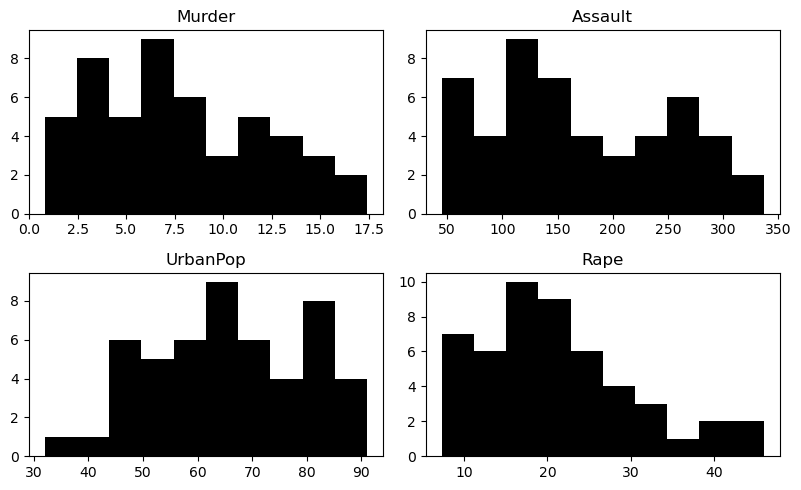

In [7]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(8, 5)) 
plt.tight_layout()
plt.show()


As we can see the values of features are inconsistent. Arrests for murder, assault and rape are counted per 100,000 people. The values differ because of the nature of siriousness of the crime. UrbanPop is given as a percentage of urban population in a given state so it's on 100 scale. 

## Correlation analysis

To determin what are the correlation between features of interest, lets see the correlation function ploted on the heatmap. We will use mask to remove the repeates of the correlation in seaborn heatmap.

In [8]:
# Calculating correlation between columns
states = df.index
corr_df = df.corr()
labels = corr_df.columns

correlations = corr_df.corr()

C:\Users\New_User\AppData\Local\Temp\ipykernel_22524\3762527075.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)


<AxesSubplot:>

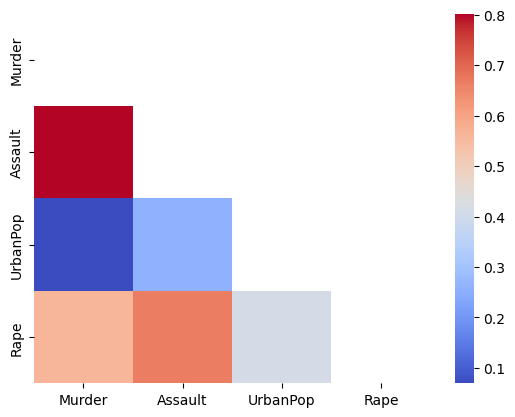

In [9]:
# Using mask to remove repeats and displaying heatmap
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

We can see a strong positive correlation between number of arrests for assault and murder, and assault and rape.
Highier percentage of urbanised population results in lowered arrests rates for rape, assault and murder. It's quite intuitive to observe lower attest rates in a more urbanised population, where the law enforcement forces are more abundant, the demand to live there is highier and possibly the income is higher as well.  
As there are high correlation between characteristics this dataset is a good candidate to perform PCA. 

## PCA

We will use Principal Components Analysis (PCA) to find underlying components that are called principal components. This method differentiate the observations where the points variance is highiest. Variables with the highiest variance dominates principal components. PCA will reduce redundancies that encode similar types of differences. This way we will be focusing on fewer dimensions.
Before that we will scale the data to show better and clearer results. 

In [10]:
# Preprocessing the data
X_std = StandardScaler().fit_transform(df)

# Performing principal component analysis with default parameters
std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)


In [11]:
# Let's see which features represent given components.

pc1 = abs(std_pca.components_[0])
pc2 = abs(std_pca.components_[1])
pc3 = abs(std_pca.components_[2])
pc4 = abs(std_pca.components_[3])

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df["PC3 Importance"] = pc3
feat_df["PC4 Importance"] = pc4
feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance,PC4 Importance
0,Murder,0.54,0.42,0.34,0.65
1,Assault,0.58,0.19,0.27,0.74
2,UrbanPop,0.28,0.87,0.38,0.13
3,Rape,0.54,0.17,0.82,0.09


These are quite closely distributed so we will look for an elbow in cumulative variance plot and scree plot. 

Text(0.5, 1.0, 'Cumulative Explained Variance')

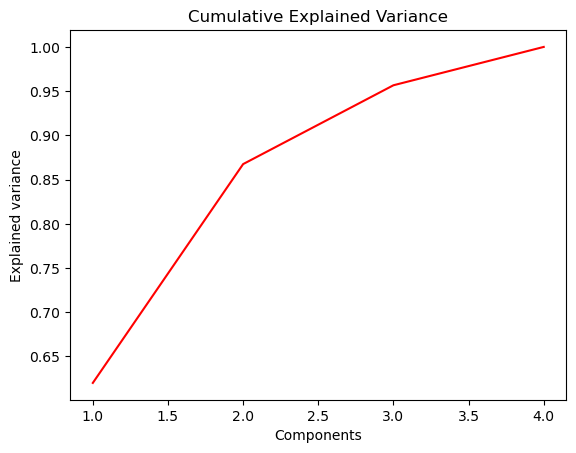

In [12]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

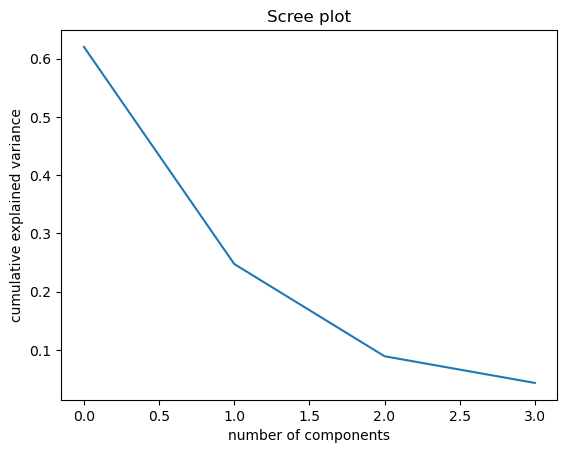

In [13]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 components explain around 90% of variance and this is satisfactory enough. We will proceed with 2 components. 

## Hierarchical clustering

In [14]:
# Choosing first two components in PCA
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
State,,
Alabama,0.99,1.13
Alaska,1.95,1.07
Arizona,1.76,-0.75
Arkansas,-0.14,1.12
California,2.52,-1.54


Now lets see dendograms for different methods and grade where the variance is the highiest. 

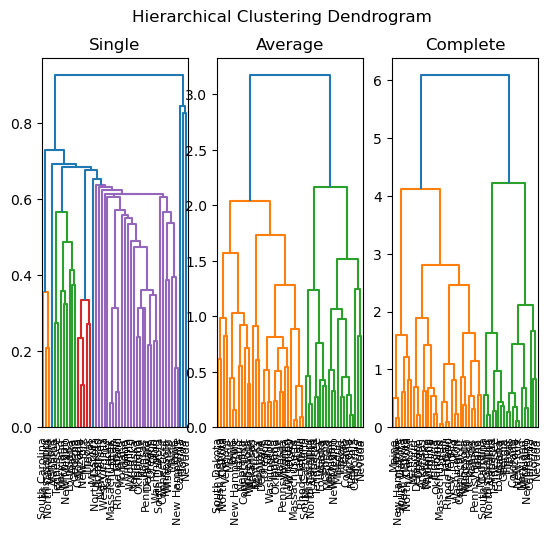

In [15]:
# Let's use Agglomerative Clustering and fit the model to principal component analysis dataframe with two components
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

# Plot dendograms foe different linkage methods
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) 
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

We can see that the highiest variance is for complete linkage method. There are 2 visible clusters. 

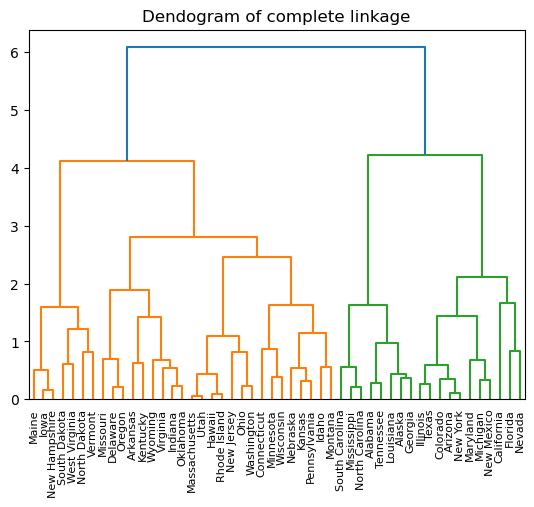

In [16]:
# More detailed picture of clusters
plt.title("Dendogram of complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

Looking at the dendogram we can specify which states are safer and which are not. The onces that are 

## K-means clustering

This method of clustering is effective if we know the number of clusters in advance and the variance is high. It convergest clusters to local optimum. In our dataset K will be set to 2. 

Text(0, 0.5, 'Component 1')

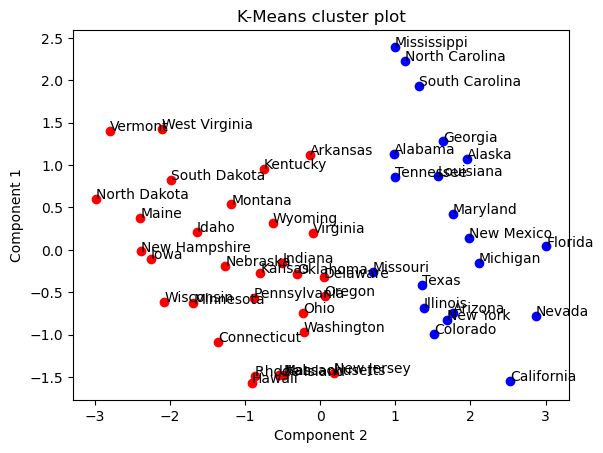

In [17]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rb'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Component 2")
ax.set_ylabel("Component 1")

Knowing that component 1 was highly dependent on arrests rates and component 2 mostly dependent on urbanization of population, we can say that the clusters were created predominantly based on urbanization level. 
We could also cluster in 4 components and see how the states will be devided then. 
Let's repeat the process.

Text(0, 0.5, 'Component 1')

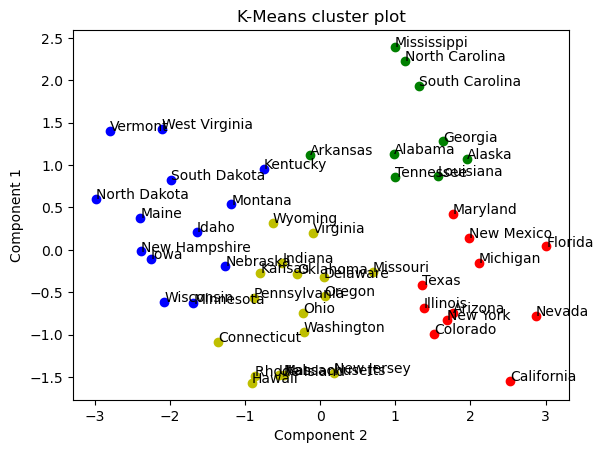

In [18]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgym'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Component 2")
ax.set_ylabel("Component 1")

Now we have states devided in groups of average arrests and low urbanized population(blue), low arrests level and average urbanized population(yellow), high urbanized population and high criminal record(green) and high urbanized population and low criminal record(red).